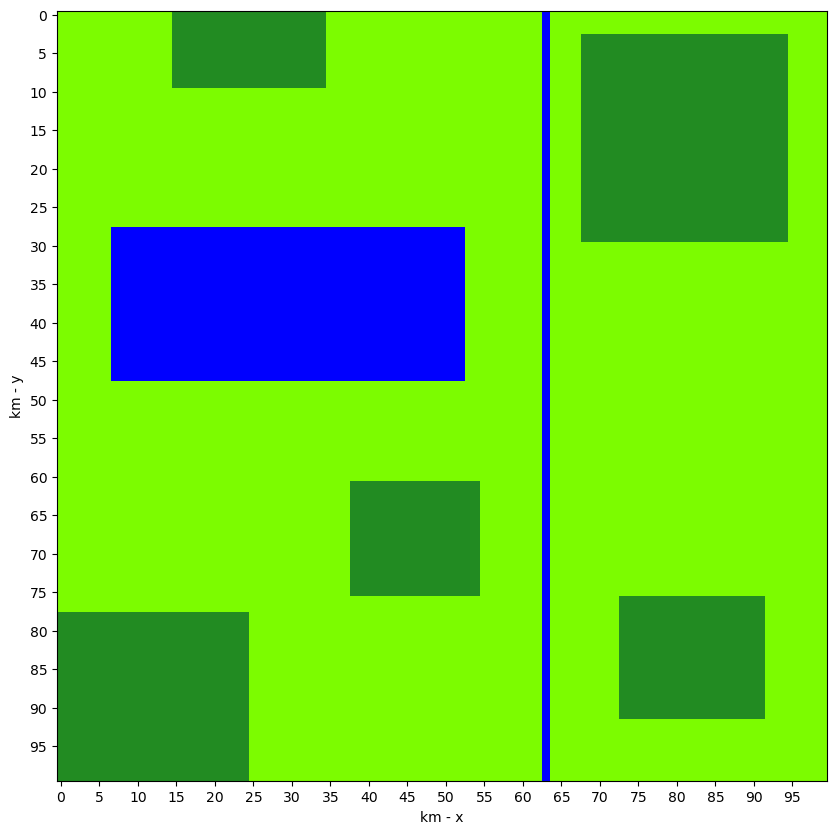

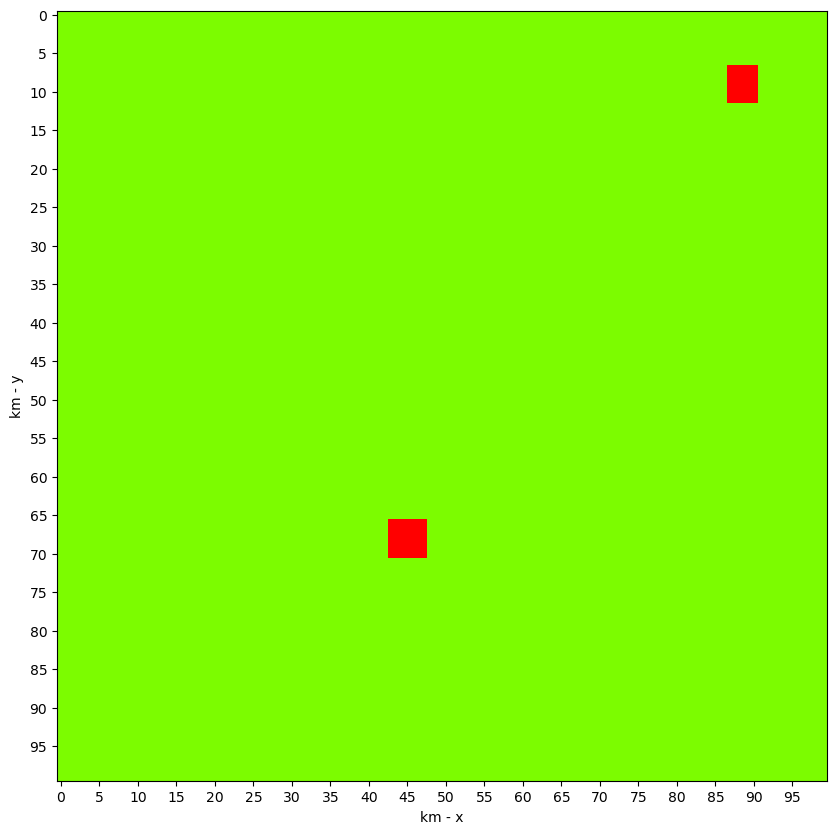

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
import numpy as np
from decimal import Decimal
import matplotlib.image as mpimg
from matplotlib import pyplot as plt, colors

susceptible = np.ones((100,100))*15

river = np.ones(100)
river[63]=0

susceptible = susceptible*river

#forest1 (lower left)
for i in range (78,100):
    for j in range (0,25):
        #susceptible[i][j]=2500
        susceptible[i][j]=100
#forest2 (middle left)
for i in range (61,76):
    for j in range (38,55):
        #susceptible[i][j]=1500
        susceptible[i][j]=100
#forest3 (upper left)
for i in range (0,10):
    for j in range (15,35):
        #susceptible[i][j]=400
        susceptible[i][j]=100
#forest4 (lower right)
for i in range (76,92):
    for j in range (73,92):
        susceptible[i][j]=100
#forest5 (upper right)
for i in range (3,30):
    for j in range (68,95):
        #susceptible[i][j]=400
        susceptible[i][j]=100
# city
for i in range (28,48):
    for j in range (7,53):
        susceptible[i][j]=0


# create discrete colormap
cmap = colors.ListedColormap(['blue','lawngreen','forestgreen'])
bounds = [0,14,99,999]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(susceptible, cmap=cmap, norm=norm)

#ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 100, 5));
ax.set_yticks(np.arange(0, 100, 5));
ax.set_xlabel('km - x')
ax.set_ylabel('km - y')

plt.show()

latent = np.zeros((100, 100))

# outbreak 1 (left)
for i in range(66, 71):
    for j in range(43, 48):
        latent[i][j] = 100

# outbreak 2 (right)
for i in range(7, 12):
    for j in range(87, 91):
        latent[i][j] = 100

# create discrete colormap
cmap = colors.ListedColormap(['lawngreen', 'red'])
bounds = [0, 100]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(latent, cmap=cmap, norm=norm)

# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 100, 5));
ax.set_yticks(np.arange(0, 100, 5));
ax.set_xlabel('km - x')
ax.set_ylabel('km - y')

plt.show()

# adjust the susceptible matrix accordingly
susceptible -= latent

#everything at 0 at the start
infected = np.zeros((100,100))


In [6]:
def sli_with_spatial_terms_2d(t, y, b, d, B, Y, a, e):
    
    """
    Parameters
    ----------
    b: Birth rate
    d: Natural death rate
    B: Infection rate
    Y: Parameter to take into account density dependent reduction in population
    a: Death rate due to infection
    e: Rate of individuals that turn infective
    """

    global ENABLE_SPATIAL_DOMAIN_TERMS
    global mask
    global size_x, factor
    global susceptible_shape,latent_shape,infected_shape

    #reshaping the S,L and I matrix to 2-d, as input y is a vector
    S, L, I = y[:size_x].reshape(susceptible_shape), \
    y[size_x:2 * size_x].reshape(latent_shape), y[2 * size_x:].reshape(infected_shape)
    
    
    N = S + L + I
    #The next three equations are responsible for the temporal spread
    dS_dt = b * N - d * S - Y * S * N - B * S * I
    dL_dt = B * S * I - d * L - Y * L * N - e * L
    dI_dt = e * L - Y * I * N - a * I - d * I
    
    #function to calculate the spatial spread
    def del_h(M):

        M = np.pad(M, 1, mode='constant')
        # Stop matrix to stop the diffusion in city and river pixels;
        # Assumption is that no diffusion happens in the city and river
        Stop = np.pad(mask, 1, mode='constant') 
        dM = np.zeros((M.shape[0], M.shape[1]))
        for i in range(1,M.shape[0]-1):
            for j in range(1,M.shape[1]-1):
                d = 4 #variable to store count of non-zero neighbors
                #d = 8 #variable to store count of non-zero neighbors
                #if M[i][j - 1] == 0: d-=1
                #if M[i][j + 1] == 0: d -= 1
                #if M[i+1][j - 1] == 0: d -= 1
                #if M[i+1][j] == 0: d -= 1
                #if M[i+1][j + 1] == 0: d -= 1
                #if M[i-1][j - 1] == 0: d -= 1
                #if M[i-1][j ] == 0: d -= 1
                #if M[i-1][j + 1] == 0: d -= 1
                    
                if M[i-1][j] == 0: d -= 1
                if M[i][j-1] == 0: d -= 1
                if M[i][j+1] == 0: d -= 1
                if M[i+1][j] == 0: d -= 1
            
                '''
                if d==0 : 
                    dM[i][j] = -(8*M[i][j])/8
                elif Stop[i][j]==0:
                    dM[i][j]=0
                else:
                    dM[i][j] = (-8 * M[i][j] + (8/d) * \
                    (M[i][j - 1] + M[i][j + 1] + M[i + 1][j - 1] + M[i + 1][j] + \
                     M[i + 1][j + 1] + M[i - 1][j - 1] + M[i - 1][j] + M[i - 1][j + 1]))/8
                '''
                
                if d==0 : 
                    dM[i][j] = -(4*M[i][j])/4
                elif Stop[i][j]==0:
                    dM[i][j]=0
                else:
                    dM[i][j] = (-4 * M[i][j] + (4/d) * \
                    (M[i-1][j] + M[i][j-1] + M[i][j+1] + M[i+1][j]))/4


        return dM[1:-1,1:-1]
    
    
    if ENABLE_SPATIAL_DOMAIN_TERMS:
        dS_dt += factor*del_h(S)
        dL_dt += factor*del_h(L)
        dI_dt += factor*del_h(I)

    return np.concatenate([dS_dt.ravel(), dL_dt.ravel(), dI_dt.ravel()])

ENABLE_SPATIAL_DOMAIN_TERMS = True

# mask matrix to store the river and city pixels;
# Assumption is that no diffusion happens in the city and river
mask = np.ones((susceptible.shape[0],susceptible.shape[1]))
for i in range(susceptible.shape[0]):
    for j in range(susceptible.shape[1]):
        if susceptible[i][j]==0 and latent[i][j]==0 and infected[i][j]==0:
            mask[i][j] = 0

diffusion_rate = 0.1
delta_x = 0.1
max_t = 20

factor = (diffusion_rate / delta_x**2)
max_delta_t = 1

susceptible_shape = susceptible.shape
latent_shape = latent.shape
infected_shape = infected.shape
y0 = np.concatenate((susceptible.ravel(),latent.ravel(),infected.ravel()))
size_x = int(y0.shape[0]/3)

"""F parameters (check function 'sli_with_spatial_terms_2d' docstring for an explanation)"""
b = 0.39
d = 0.125
B = 0.6
Y = 0.01
a = 0.9
e = 0.3

sol = solve_ivp(
    fun=sli_with_spatial_terms_2d,
    t_span=[0, max_t],
    t_eval=np.linspace(0, max_t, 2001),
    y0=y0,
    args=(b, d, B, Y, a, e),
    max_step=max_delta_t
    )


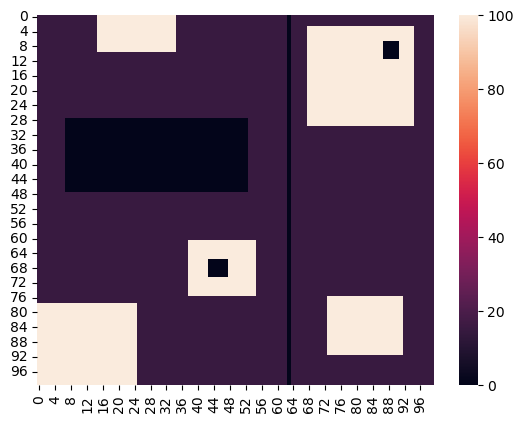

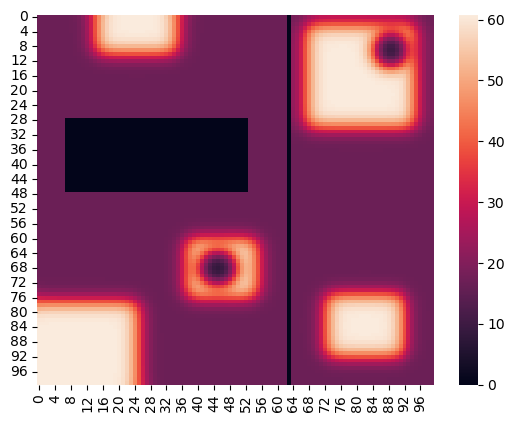

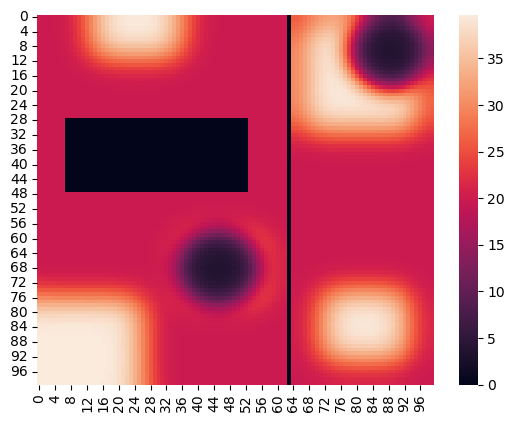

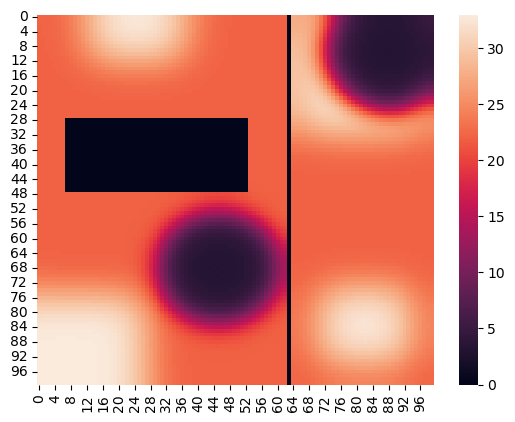

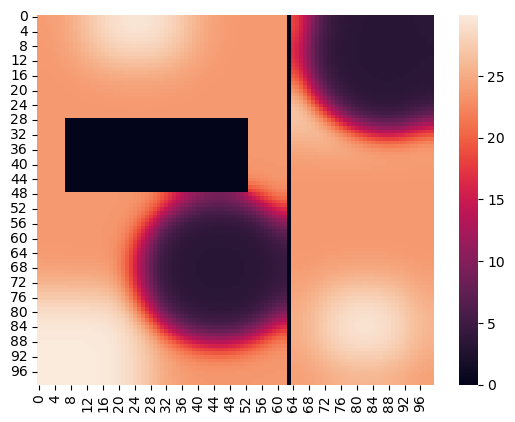

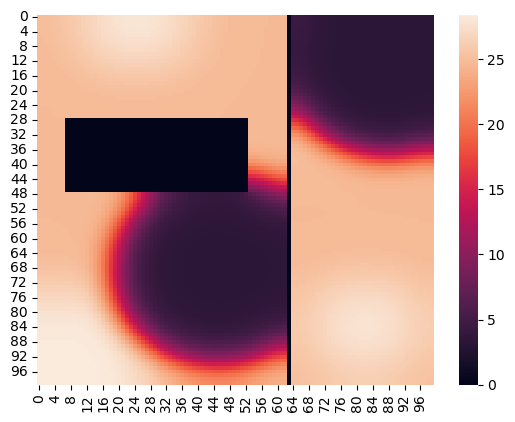

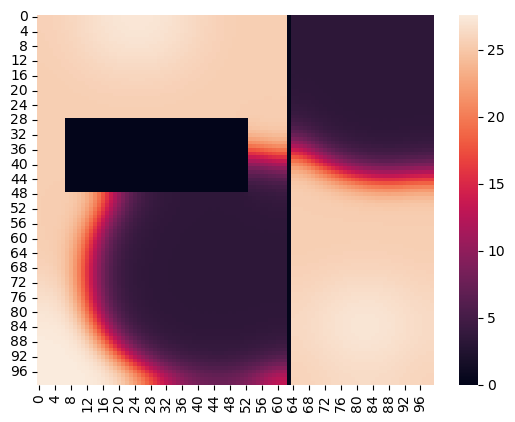

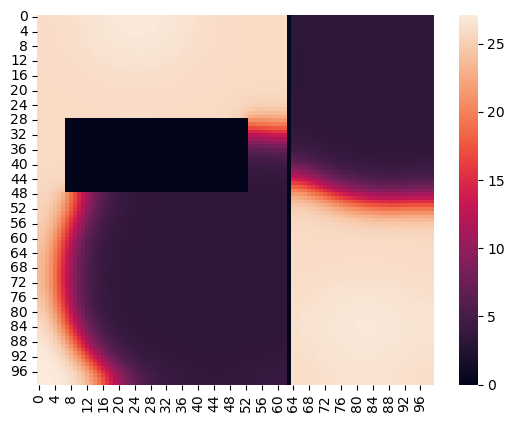

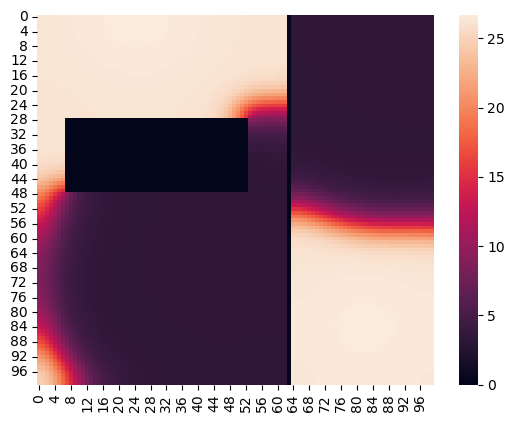

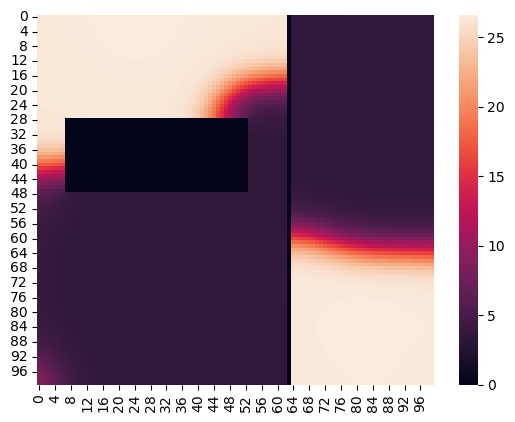

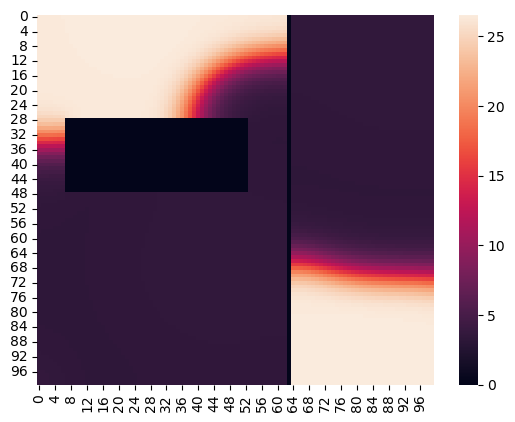

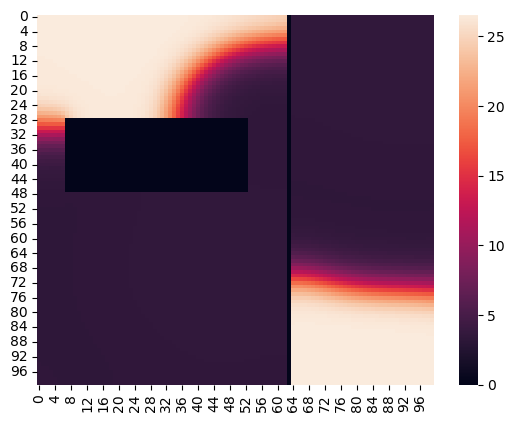

In [7]:
#Code to generate heatmaps of how susceptible population is changing with time
Su = sol.y[:size_x]
su = np.empty((2001,susceptible.shape[0],susceptible.shape[1]))
for i in range(2001):
     su[i]=Su[:,i].reshape(susceptible_shape)
        
for i in [0,100,300,500,700,900,1100,1300,1500,1700,1900,2000]:
    sns.heatmap(su[i])
    plt.show()

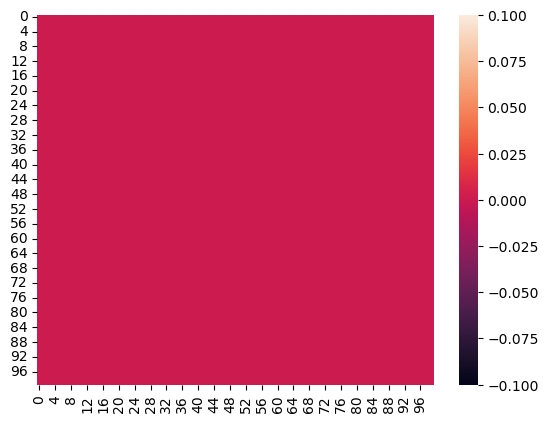

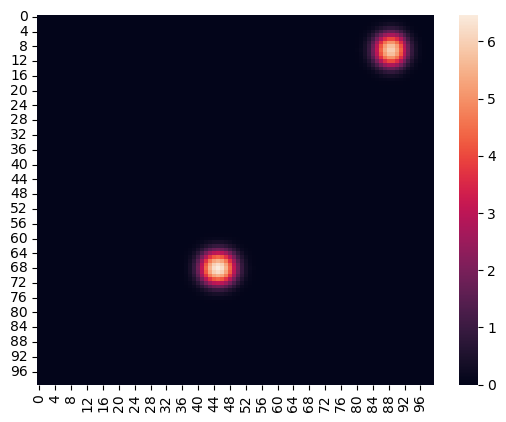

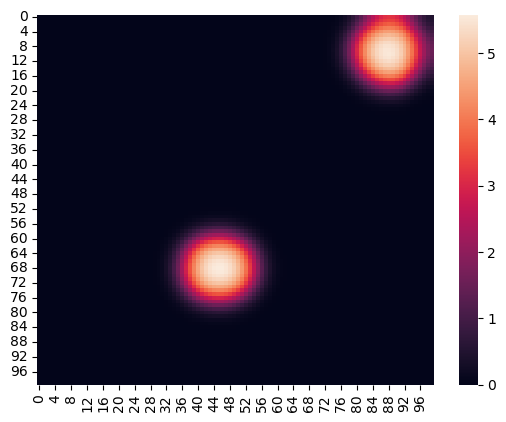

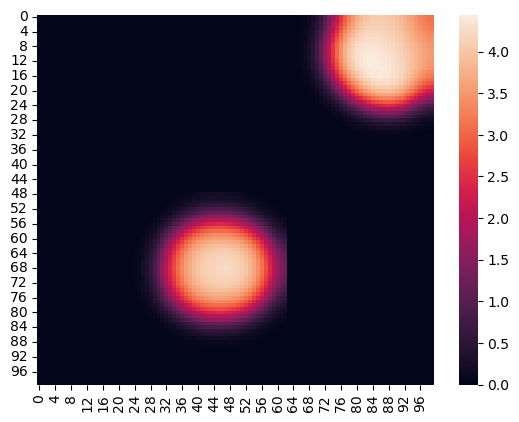

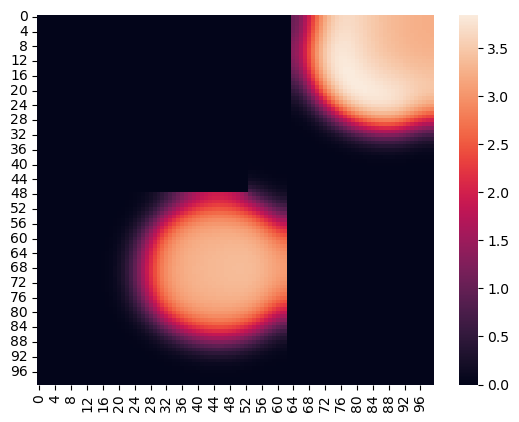

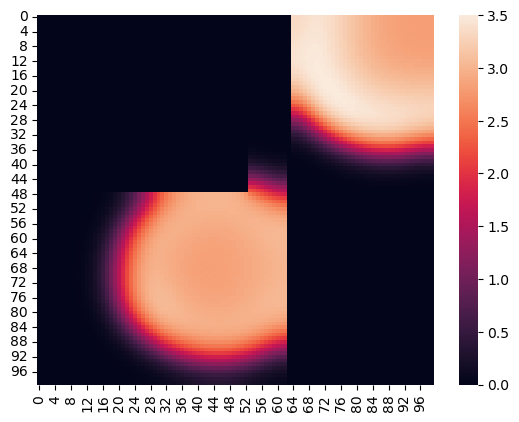

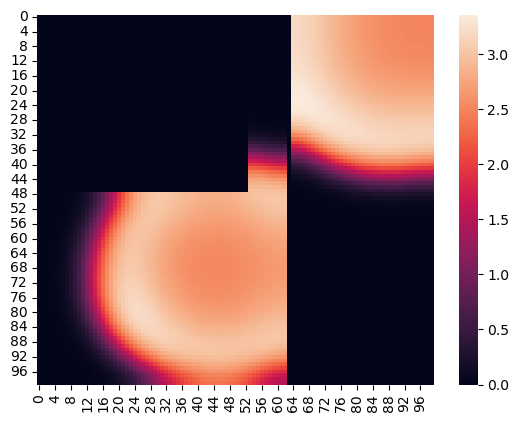

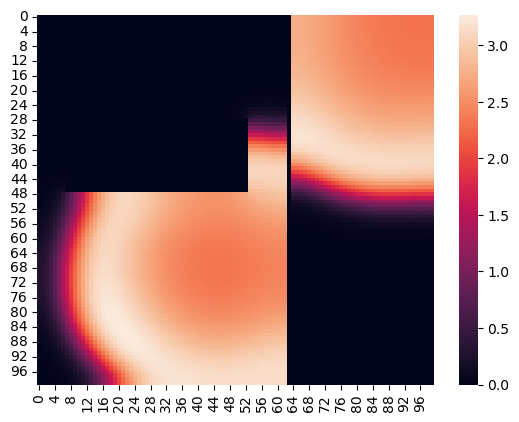

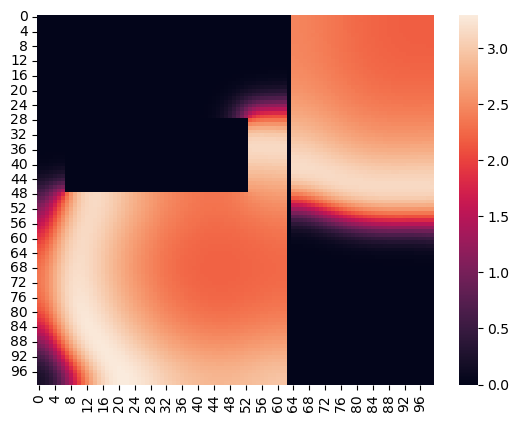

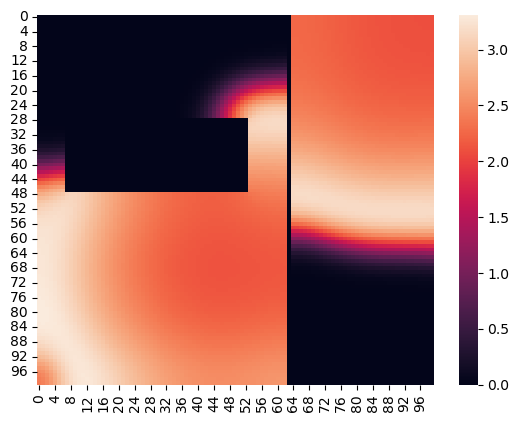

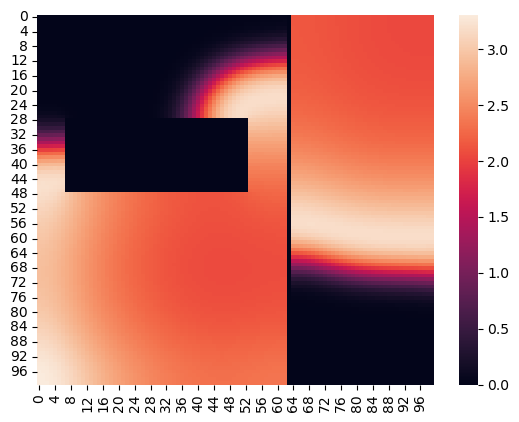

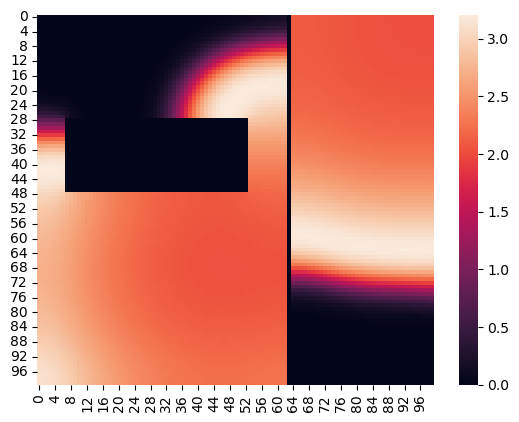

In [4]:
# Code to generate heatmaps of how infective population is changing with time
In = sol.y[2*size_x:]
infe = np.empty((2001,susceptible.shape[0],susceptible.shape[1]))
for i in range(2001):
     infe[i]=In[:,i].reshape(susceptible_shape)
for i in [0,100,300,500,700,900,1100,1300,1500,1700,1900,2000]:
    sns.heatmap(infe[i])
    plt.show()